# Subway Cleaning v2
---
When we first explored the Subway data, we used a script in order to loosly clean the data and then tried tidying it up manually. This was adequate for an initial exploration. However, upon testing models as well as exploring the dataset further, we realised we would need to revisit the original dataset and clean it more throughly in order to merge it sucessfully to both the February-December data, as well as improve model performance.

The cleaning steps will be largely based off the following article by Chris Whong: https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0

In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import calendar
from shapely.geometry import Point, Polygon
import os

from sklearn.neighbors import BallTree

## Manual Cleaning - Excel
---
We decided to start over from the original uncleaned data as the cleaned data we had original was not apt, and missed some key details during the cleaning as well as removed rows which we may be able to keep. As such, we filter and save the January turnstile usage to a new csv file.

In [ ]:
df = pd.read_csv('Subway_Data/Turnstile_Usage_Data__2022.csv')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df[(df['Date'].dt.month == 1) & (df['Date'].dt.year == 2022)]

In [ ]:
df

In [ ]:
df.to_csv('2022_jan_uncleaned_subway.csv', index=False)

### Steps Taken:
Before beginning our cleaning in pandas, the csv file was manually edited in excel for some preliminary additions that would make cleaning easier. In short:
- Two other csv files, stations and a remote complex lookup were added to the excel file.
- using these as well as unique ids, VLOOKUP was used to link and add extra columns to the subway data that will be usefull for our analysis.
- These include complex and station ids, boroughs for filtering, as well as lat and lon co-ordrinates for each station
- Miscellaneous cleaning such as removing whitespace in columns headings etc.
A more in-depth writeup detailing the steps taken will be written in a dev log on notion.

## Cleaning
---
After manually working on the excel file, we can now load in the new dataset with added features and being the actual cleaning process.

In [2]:
df_raw = pd.read_csv('Subway_Data/2022_jan_uncleaned_subway_formatted.csv')

In [3]:
df_raw

,C/A,Unit,SCP,Complex_id,Station,station_id,stop_name,borough,latitude,longitude,Line Name,Division,Date,Time,Description,Entries,Exits
0,A002,R051,02-00-00,613,59 ST,7.0,Lexington Av/59 St,M,40.76266,-73.967258,NQR456W,BMT,31/01/2022,03:00:00,REGULAR,7682666,2660008
1,A002,R051,02-00-00,613,59 ST,7.0,Lexington Av/59 St,M,40.76266,-73.967258,NQR456W,BMT,31/01/2022,07:00:00,REGULAR,7682667,2660049
2,A002,R051,02-00-00,613,59 ST,7.0,Lexington Av/59 St,M,40.76266,-73.967258,NQR456W,BMT,31/01/2022,11:00:00,REGULAR,7682688,2660273
3,A002,R051,02-00-00,613,59 ST,7.0,Lexington Av/59 St,M,40.76266,-73.967258,NQR456W,BMT,31/01/2022,15:00:00,REGULAR,7682737,2660345
4,A002,R051,02-00-00,613,59 ST,7.0,Lexington Av/59 St,M,40.76266,-73.967258,NQR456W,BMT,31/01/2022,19:00:00,REGULAR,7682900,2660428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928887,TRAM2,R469,00-05-01,0,RIT-ROOSEVELT,NaN,NaN,NaN,NaN,NaN,R,RIT,01/01/2022,00:00:00,REGULAR,5562,1001
928888,TRAM2,R469,00-05-01,0,RIT-ROOSEVELT,NaN,NaN,NaN,NaN,NaN,R,RIT,01/01/2022,04:00:00,REGULAR,5562,1001
928889,TRAM2,R469,00-05-01,0,RIT-ROOSEVELT,NaN,NaN,NaN,NaN,NaN,R,RIT,01/01/2022,08:00:00,REGULAR,5562,1001
928890,TRAM2,R469,00-05-01,0,RIT-ROOSEVELT,NaN,NaN,NaN,NaN,NaN,R,RIT,01/01/2022,16:00:00,REGULAR,5562,1006


In [4]:
df_raw.head(), df_raw.columns.tolist()

(    C/A  Unit       SCP  Complex_id Station  station_id           stop_name  \
 0  A002  R051  02-00-00         613   59 ST         7.0  Lexington Av/59 St   
 1  A002  R051  02-00-00         613   59 ST         7.0  Lexington Av/59 St   
 2  A002  R051  02-00-00         613   59 ST         7.0  Lexington Av/59 St   
 3  A002  R051  02-00-00         613   59 ST         7.0  Lexington Av/59 St   
 4  A002  R051  02-00-00         613   59 ST         7.0  Lexington Av/59 St   
 
   borough  latitude  longitude Line Name Division        Date      Time  \
 0       M  40.76266 -73.967258   NQR456W      BMT  31/01/2022  03:00:00   
 1       M  40.76266 -73.967258   NQR456W      BMT  31/01/2022  07:00:00   
 2       M  40.76266 -73.967258   NQR456W      BMT  31/01/2022  11:00:00   
 3       M  40.76266 -73.967258   NQR456W      BMT  31/01/2022  15:00:00   
 4       M  40.76266 -73.967258   NQR456W      BMT  31/01/2022  19:00:00   
 
   Description  Entries    Exits  
 0     REGULAR  7682666  

Filter to only include Manhattan stations.

In [5]:
df_raw = df_raw[df_raw['borough'] == 'M'].reset_index(drop=True)

In [6]:
df_raw

,C/A,Unit,SCP,Complex_id,Station,station_id,stop_name,borough,latitude,longitude,Line Name,Division,Date,Time,Description,Entries,Exits
0,A002,R051,02-00-00,613,59 ST,7.0,Lexington Av/59 St,M,40.762660,-73.967258,NQR456W,BMT,31/01/2022,03:00:00,REGULAR,7682666,2660008
1,A002,R051,02-00-00,613,59 ST,7.0,Lexington Av/59 St,M,40.762660,-73.967258,NQR456W,BMT,31/01/2022,07:00:00,REGULAR,7682667,2660049
2,A002,R051,02-00-00,613,59 ST,7.0,Lexington Av/59 St,M,40.762660,-73.967258,NQR456W,BMT,31/01/2022,11:00:00,REGULAR,7682688,2660273
3,A002,R051,02-00-00,613,59 ST,7.0,Lexington Av/59 St,M,40.762660,-73.967258,NQR456W,BMT,31/01/2022,15:00:00,REGULAR,7682737,2660345
4,A002,R051,02-00-00,613,59 ST,7.0,Lexington Av/59 St,M,40.762660,-73.967258,NQR456W,BMT,31/01/2022,19:00:00,REGULAR,7682900,2660428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408284,R551,R072,01/05/2001,471,34 ST-HUDSON YD,471.0,34 St - 11 Av,M,40.755882,-74.001910,7,IRT,01/01/2022,19:00:00,RECOVR AUD,1,271
408285,R551,R072,01/05/2001,471,34 ST-HUDSON YD,471.0,34 St - 11 Av,M,40.755882,-74.001910,7,IRT,01/01/2022,23:00:00,RECOVR AUD,1,271
408286,R551,R072,01/05/2001,471,34 ST-HUDSON YD,471.0,34 St - 11 Av,M,40.755882,-74.001910,7,IRT,01/01/2022,03:00:00,REGULAR,1,270
408287,R551,R072,01/05/2001,471,34 ST-HUDSON YD,471.0,34 St - 11 Av,M,40.755882,-74.001910,7,IRT,01/01/2022,07:00:00,REGULAR,1,270


I want to make sure the cleaning in the excel using VLOOKUP matched complex ids correctly. As such, I'm simply printing the number of unique values for complex id after filtering for Manhattan.

In [7]:
df_raw['Complex_id'].nunique()

121

From online 'There are 151 New York City Subway stations in Manhattan, per the official count of the Metropolitan Transportation Authority (MTA); of these, 32 are express-local stations. If the 18 station complexes are counted as one station each, the number of stations is 121.'

This all checks out.

**Modifying the raw data:**
As per above, we are following the article linked to make cleaning easier and more manageable. We are impleneting a few modifications outlined in the article to make merging and modelling the data easier:
- A unique turnstile ID is created by concatenating the C/A, Unit, and SCP columns. From the article, this prevents duplicate observations which occur in the data.
- A timestamp is extracted from the Date and Time columns to allow for easy grouping.
- The difference in entries and exits are calculated by subtracting the previous entry from the current one. For edge cases where the counter is counting down instead of up we also take the absolute value to avoid negatives.

In [8]:
# Create a unique ID for each turnstile by combining 'C/A', 'Unit', and 'SCP'
df_raw['turnstile_id'] = df_raw['C/A'] + df_raw['Unit'] + df_raw['SCP']

# Combine Date and Time into a new timestamp
df_raw['timestamp'] = pd.to_datetime(df_raw['Date'] + ' ' + df_raw['Time'], format='%d/%m/%Y %H:%M:%S')

# Sort the data by 'turnstile_id' and 'DATETIME'
df_raw.sort_values(['turnstile_id', 'timestamp'], inplace=True)

# Caluclate differnce in entries/exits from previous recording
df_raw['Entries_diff'] = df_raw.groupby('turnstile_id')['Entries'].diff()
df_raw['Exits_diff'] = df_raw.groupby('turnstile_id')['Exits'].diff()

# Use absolute values to handle rare case of counters counting donwards
df_raw['Entries_diff'] = df_raw['Entries_diff'].abs()
df_raw['Exits_diff'] = df_raw['Exits_diff'].abs()

**Handling Turnstile Counter Resets:**
Once the turnstile counter reaches a certain limit, the count resets. To avoid this creating extrem values in the difference, we set a cutoff at 10,000. Any entries in excess are also reset in the count, thus starting the count over correctly.

In [9]:
# Set a cutoff value
cutoff_value = 10000

# Replacing values above 10,000 with NaN
df_raw.loc[df_raw['Entries_diff'] > cutoff_value, 'Entries_diff'] = np.nan
df_raw.loc[df_raw['Exits_diff'] > cutoff_value, 'Exits_diff'] = np.nan

df_raw.head()

,C/A,Unit,SCP,Complex_id,Station,station_id,stop_name,borough,latitude,longitude,...,Division,Date,Time,Description,Entries,Exits,turnstile_id,timestamp,Entries_diff,Exits_diff
395138,A002,R051,02-00-00,613,59 ST,7.0,Lexington Av/59 St,M,40.76266,-73.967258,...,BMT,01/01/2022,03:00:00,REGULAR,7675872,2649548,A002R05102-00-00,2022-01-01 03:00:00,NaN,NaN
395139,A002,R051,02-00-00,613,59 ST,7.0,Lexington Av/59 St,M,40.76266,-73.967258,...,BMT,01/01/2022,07:00:00,REGULAR,7675876,2649551,A002R05102-00-00,2022-01-01 07:00:00,4.0,3.0
395140,A002,R051,02-00-00,613,59 ST,7.0,Lexington Av/59 St,M,40.76266,-73.967258,...,BMT,01/01/2022,11:00:00,REGULAR,7675887,2649594,A002R05102-00-00,2022-01-01 11:00:00,11.0,43.0
395141,A002,R051,02-00-00,613,59 ST,7.0,Lexington Av/59 St,M,40.76266,-73.967258,...,BMT,01/01/2022,15:00:00,REGULAR,7675895,2649626,A002R05102-00-00,2022-01-01 15:00:00,8.0,32.0
395142,A002,R051,02-00-00,613,59 ST,7.0,Lexington Av/59 St,M,40.76266,-73.967258,...,BMT,01/01/2022,19:00:00,REGULAR,7675920,2649657,A002R05102-00-00,2022-01-01 19:00:00,25.0,31.0


Since we have a unique identifier for each turnstile, these ID's will no longer be required or provide any additional information. As such, we drop them.

In [10]:
df_raw = df_raw.drop(['C/A', 'Unit', 'SCP'], axis=1)

In [11]:
df_raw

,Complex_id,Station,station_id,stop_name,borough,latitude,longitude,Line Name,Division,Date,Time,Description,Entries,Exits,turnstile_id,timestamp,Entries_diff,Exits_diff
395138,613,59 ST,7.0,Lexington Av/59 St,M,40.762660,-73.967258,NQR456W,BMT,01/01/2022,03:00:00,REGULAR,7675872,2649548,A002R05102-00-00,2022-01-01 03:00:00,NaN,NaN
395139,613,59 ST,7.0,Lexington Av/59 St,M,40.762660,-73.967258,NQR456W,BMT,01/01/2022,07:00:00,REGULAR,7675876,2649551,A002R05102-00-00,2022-01-01 07:00:00,4.0,3.0
395140,613,59 ST,7.0,Lexington Av/59 St,M,40.762660,-73.967258,NQR456W,BMT,01/01/2022,11:00:00,REGULAR,7675887,2649594,A002R05102-00-00,2022-01-01 11:00:00,11.0,43.0
395141,613,59 ST,7.0,Lexington Av/59 St,M,40.762660,-73.967258,NQR456W,BMT,01/01/2022,15:00:00,REGULAR,7675895,2649626,A002R05102-00-00,2022-01-01 15:00:00,8.0,32.0
395142,613,59 ST,7.0,Lexington Av/59 St,M,40.762660,-73.967258,NQR456W,BMT,01/01/2022,19:00:00,REGULAR,7675920,2649657,A002R05102-00-00,2022-01-01 19:00:00,25.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13205,471,34 ST-HUDSON YD,471.0,34 St - 11 Av,M,40.755882,-74.001910,7,IRT,31/01/2022,07:00:00,REGULAR,1,287,R551R07201/05/2001,2022-01-31 07:00:00,0.0,0.0
13206,471,34 ST-HUDSON YD,471.0,34 St - 11 Av,M,40.755882,-74.001910,7,IRT,31/01/2022,11:00:00,REGULAR,1,287,R551R07201/05/2001,2022-01-31 11:00:00,0.0,0.0
13207,471,34 ST-HUDSON YD,471.0,34 St - 11 Av,M,40.755882,-74.001910,7,IRT,31/01/2022,15:00:00,REGULAR,1,287,R551R07201/05/2001,2022-01-31 15:00:00,0.0,0.0
13208,471,34 ST-HUDSON YD,471.0,34 St - 11 Av,M,40.755882,-74.001910,7,IRT,31/01/2022,19:00:00,REGULAR,1,287,R551R07201/05/2001,2022-01-31 19:00:00,0.0,0.0


**Checking for null values:**

In [12]:
df_raw.isnull().sum()

Complex_id         0
Station            0
station_id         0
stop_name          0
borough            0
latitude           0
longitude          0
Line Name          0
Division           0
Date               0
Time               0
Description        0
Entries            0
Exits              0
turnstile_id       0
timestamp          0
Entries_diff    2228
Exits_diff      2221
dtype: int64

Approximately 2,200 missing values out of over 400,000 rows seems quite reasonable. These are likely due to turnstile counters resetting. This is a much better improvement over our original script, which saw around 20% of the values missing after cleaning. 

**Checking for negatives/outliers:**

In [13]:
df_raw.describe()

,Complex_id,station_id,latitude,longitude,Entries,Exits,Entries_diff,Exits_diff
count,408289.000000,408289.000000,408289.000000,408289.000000,4.082890e+05,4.082890e+05,406061.000000,406068.000000
mean,404.803377,205.296099,40.753648,-73.983439,4.698434e+07,4.133612e+07,56.035054,77.739445
std,198.181432,149.183271,0.036511,0.021887,2.336787e+08,2.197033e+08,85.792912,121.810930
min,8.000000,7.000000,40.703087,-74.014065,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,232.000000,23.000000,40.725297,-74.001775,3.127410e+05,1.767000e+05,4.000000,7.000000
50%,404.000000,167.000000,40.751776,-73.986754,1.663161e+06,1.211348e+06,23.000000,33.000000
75%,611.000000,324.000000,40.768141,-73.972323,6.841843e+06,5.053658e+06,73.000000,98.000000
max,635.000000,477.000000,40.874561,-73.909831,2.128581e+09,2.049503e+09,9943.000000,8968.000000


No extreme outliers or negative values are present. The modifications have worked as intended, again all looks good.

### Visualisations:
---
To be extra safe, I will perform the visualtions used in the original data exploration to make sure it's consitent with our original insights. 

In [14]:
df_raw['Date'] = pd.to_datetime(df_raw['Date'])
df_raw['Time'] = pd.to_datetime(df_raw['Time'])

df_raw['Hour'] = df_raw['Time'].dt.hour
df_raw['Day'] = df_raw['Date'].dt.day_name()

/var/folders/z5/cyzw6yrn20x4mjv12bhwf7pm0000gn/T/ipykernel_64061/4186077067.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_raw['Date'] = pd.to_datetime(df_raw['Date'])


In [15]:
plt.rcParams['figure.figsize'] = (10, 6)

### Ridership per Day of the Week

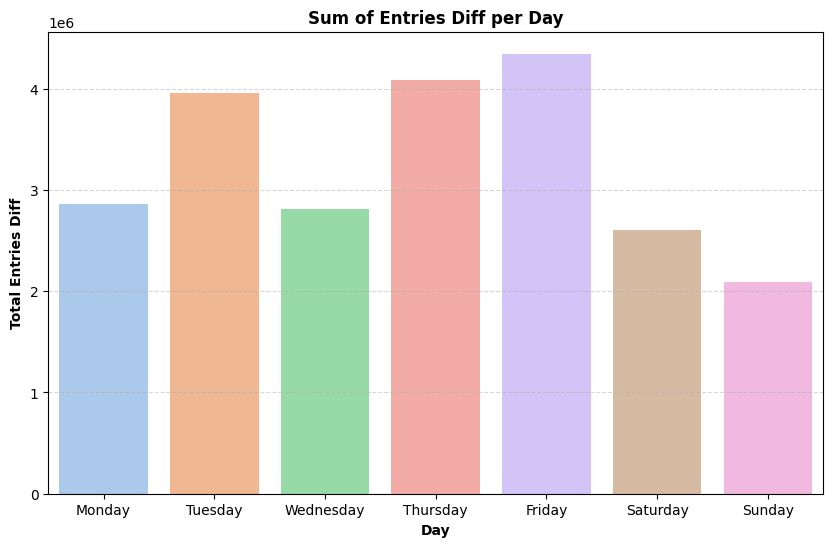

In [16]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

daily_entries_diff = df_raw.groupby('Day')['Entries_diff'].sum()

sns.barplot(x=daily_entries_diff.index, y=daily_entries_diff.values, order=day_order, palette='pastel')

plt.xlabel('Day', fontweight='bold')
plt.ylabel('Total Entries Diff', fontweight='bold')
plt.title('Sum of Entries Diff per Day', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

**Observations:**
- It's a little odd how low Monday and Wednesday are.
- But in general it seems in line with previous analysis.
- Weekends are much quieter than weekdays. This holds true with the February-December data.

### Ridership per Hour

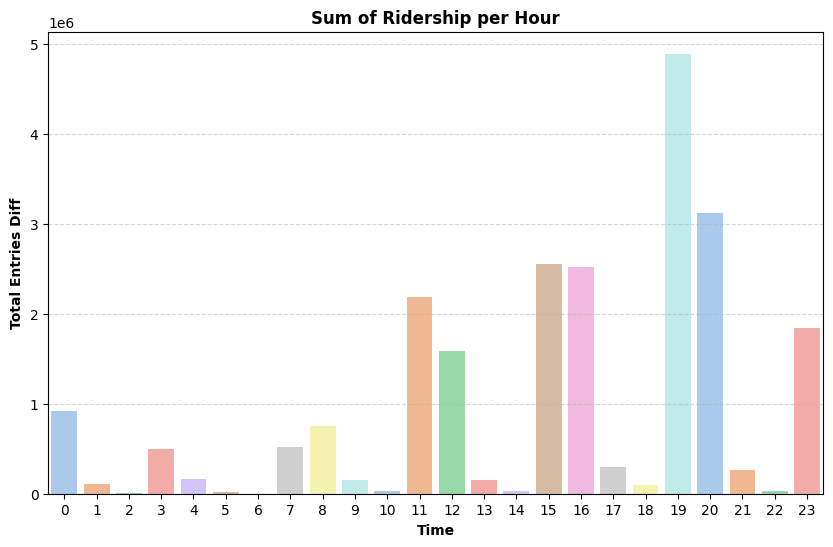

In [17]:
hourly_entries_diff = df_raw.groupby('Hour')['Entries_diff'].sum()

sns.barplot(x=hourly_entries_diff.index, y=hourly_entries_diff.values, palette='pastel')

plt.xlabel('Time', fontweight='bold')
plt.ylabel('Total Entries Diff', fontweight='bold')
plt.title('Sum of Ridership per Hour', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [18]:
hourly_entries_diff

Hour
0      924870.0
1      110918.0
2        9582.0
3      495020.0
4      164594.0
5       14872.0
6        2362.0
7      515247.0
8      750007.0
9      156190.0
10      30123.0
11    2188330.0
12    1581893.0
13     154201.0
14      30738.0
15    2556887.0
16    2524179.0
17     292067.0
18      93526.0
19    4893504.0
20    3118134.0
21     267603.0
22      34107.0
23    1844696.0
Name: Entries_diff, dtype: float64

**Observations:**
- Much like before, we see the hourly counts looks a bit weird.
- This is due to the 4-hour observation windows, as well as not all turnstiles having the same windows.
- We will use time blocks to try visualise a bit better.

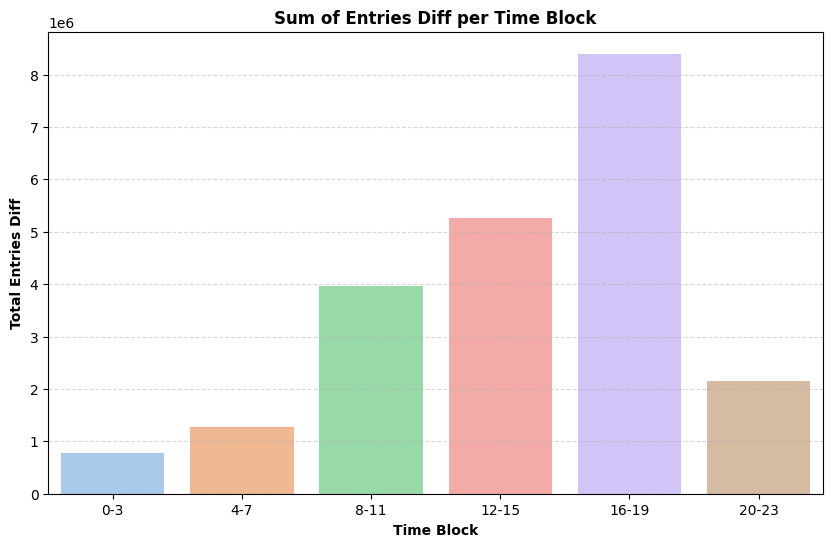

In [19]:
# Create a new column 'Time Block' based on the 'Hour' column
df_raw['Time Block'] = pd.cut(df_raw['Hour'], bins=range(0, 25, 4), labels=['0-3', '4-7', '8-11', '12-15', '16-19', '20-23'])

# Group by 'Time Block' and calculate the sum of 'Entries_diff' per block
blocked_hourly_entries_diff = df_raw.groupby('Time Block')['Entries_diff'].sum()

sns.barplot(x=blocked_hourly_entries_diff.index, y=blocked_hourly_entries_diff.values, palette='pastel')

plt.xlabel('Time Block', fontweight='bold')
plt.ylabel('Total Entries Diff', fontweight='bold')
plt.title('Sum of Entries Diff per Time Block', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [20]:
blocked_hourly_entries_diff

Time Block
0-3       780114.0
4-7      1282488.0
8-11     3956536.0
12-15    5266005.0
16-19    8397231.0
20-23    2146406.0
Name: Entries_diff, dtype: float64

**Observations:**
- This looks much better again.
- Late at night is queitest, with an uptick in the morning and afternoon before peaking in the evening and gradually declining again at night.
- We will convert these time blocks into hourly counts later on in the cleaning process.

### Ridership per Station Complex

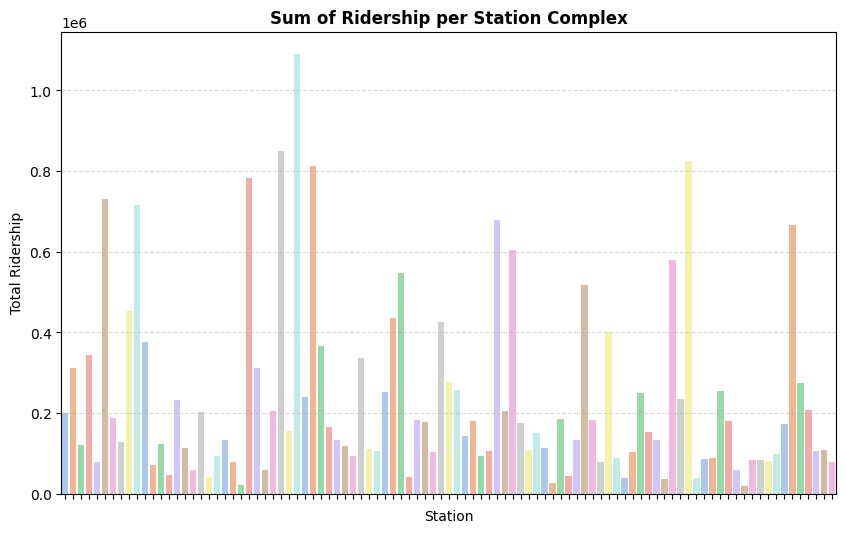

In [21]:
#station_ridership = df.groupby('Station')['ENTRIESn_hourly'].sum()
station_ridership = df_raw.groupby('Station')['Entries_diff'].sum()


# Plot the sum of ridership per station complex in a similar style
ax = sns.barplot(x=station_ridership.index, y=station_ridership.values, palette='pastel')
ax.set(xlabel='Station', ylabel='Total Ridership')
ax.set_title('Sum of Ridership per Station Complex', fontweight='bold')

ax.set_xticklabels([])  

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

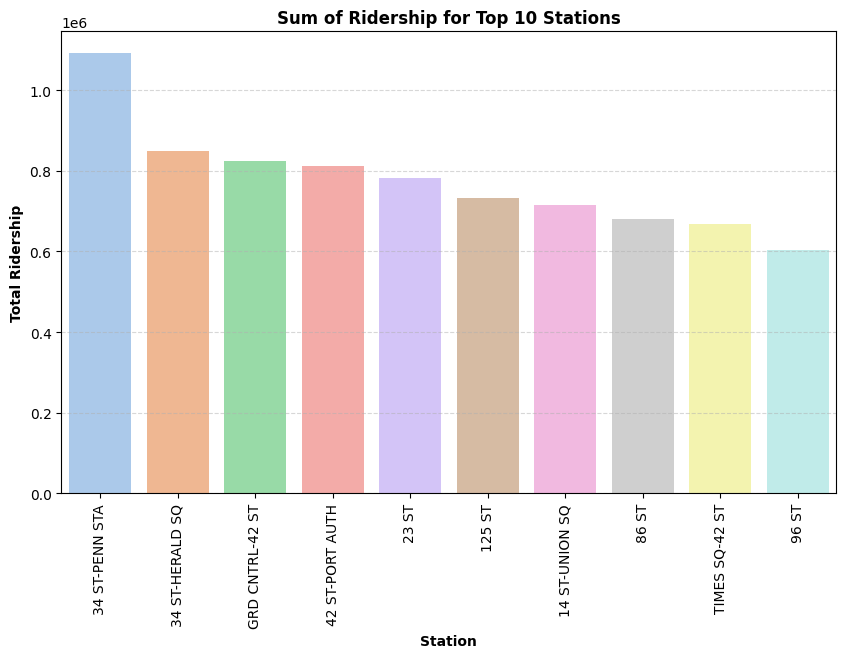

In [22]:
# Select the top 10 largest values
top_10_stations = station_ridership.nlargest(10)

# Plot the sum of ridership for the top 10 largest station complexes
sns.barplot(x=top_10_stations.index, y=top_10_stations.values, palette='pastel')
plt.xlabel('Station', fontweight='bold')
plt.ylabel('Total Ridership', fontweight='bold')
plt.title('Sum of Ridership for Top 10 Stations', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.xticks(rotation=90)

plt.show()

**Observations:**
- This may seem inconsistent with the February-December findings, where times square towered above the rest. However, it makes sense once looking furhter into it.
- The new format groups by station complexes. Larger station complexes may actually coontain more than one station.
- Not visualised here, during testing I graphed the top 10 largest complex ids and manually looked them up in the stations csv file. 
- Upon further inspection, it is actually consistent with the later data. This is simply again due to stations and station complexes being two separate entities.

The data seems consistent with the newwer format. The next step will be getting station complex names into the January data, as currently we only have IDs.

## Adding Station Complex Names to January
---
- Merging the two datasets is not as easy as it first seems due to the completely different format. 
- The main concern is getting Station Complexes into the January data. Stations are not equivalent to station complexes and as such would misrepresent busyness. 
- Originally, my idea and the reasoning behind matching the 3 csvs in Excel was to use the complex id and try extract the Station complex from the February data by matching on complex IDs. 
- Unfortunately, for some strange reason it appears as though these IDs have also changed, as when testing they did not match. So, another solution is needed. 

In [23]:
df = df_raw.copy()

In [24]:
df2 = pd.read_csv("2022_subway_feb_onwards_cleaned.csv")

In [25]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951420 entries, 0 to 951419
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transit_timestamp   951420 non-null  object 
 1   station_complex_id  951420 non-null  object 
 2   station_complex     951420 non-null  object 
 3   borough             951420 non-null  object 
 4   routes              951420 non-null  object 
 5   payment_method      951420 non-null  object 
 6   ridership           951420 non-null  int64  
 7   transfers           951420 non-null  int64  
 8   latitude            951420 non-null  float64
 9   longitude           951420 non-null  float64
 10  Georeference        951420 non-null  object 
 11  date                951420 non-null  object 
 12  hour                951420 non-null  int64  
 13  day                 951420 non-null  object 
 14  month               951420 non-null  int64  
dtypes: float64(2), int64(4), object(9)

**The Idea:** 
- As we can see, both datasets have latitude and longitude. 
- We will create a mapping table which links each station complex to the corresponding pair of co-ordinates. 
- This table can then be used to hopefully match the co-ordinate pairs in January, and add the correct complex for each turnstile. 
- Georeference is also kept as it may help later when assigning stations to zones in the modelling.

In [26]:
mapping = df2[['station_complex', 'latitude', 'longitude', 'Georeference']].copy()

In [27]:
# Drop duplicates as we only need one entry for each complex
mapping = mapping.drop_duplicates(subset='station_complex').copy()

In [28]:
mapping

,station_complex,latitude,longitude,Georeference
0,WTC Cortlandt (1),40.711834,-74.012190,POINT (-74.01219 40.711834)
1,191 St (1),40.855225,-73.929410,POINT (-73.92941 40.855225)
2,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",40.749718,-73.987820,POINT (-73.98782 40.749718)
3,"Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortla...",40.714110,-74.008580,POINT (-74.00858 40.71411)
4,145 St (3),40.820420,-73.936250,POINT (-73.93625 40.82042)
...,...,...,...,...
1503,"Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)",40.725914,-73.994660,POINT (-73.99466 40.725914)
1505,Cathedral Pkwy-110 St (1),40.803967,-73.966850,POINT (-73.96685 40.803967)
1528,"57 St-7 Av (N,Q,R,W)",40.764664,-73.980660,POINT (-73.98066 40.764664)
1548,215 St (1),40.869446,-73.915276,POINT (-73.915276 40.869446)


The mapping table seems good. Just out of curiosity, we will plot the markers on a scatter plot for a very rough visualisation of the stations layout.

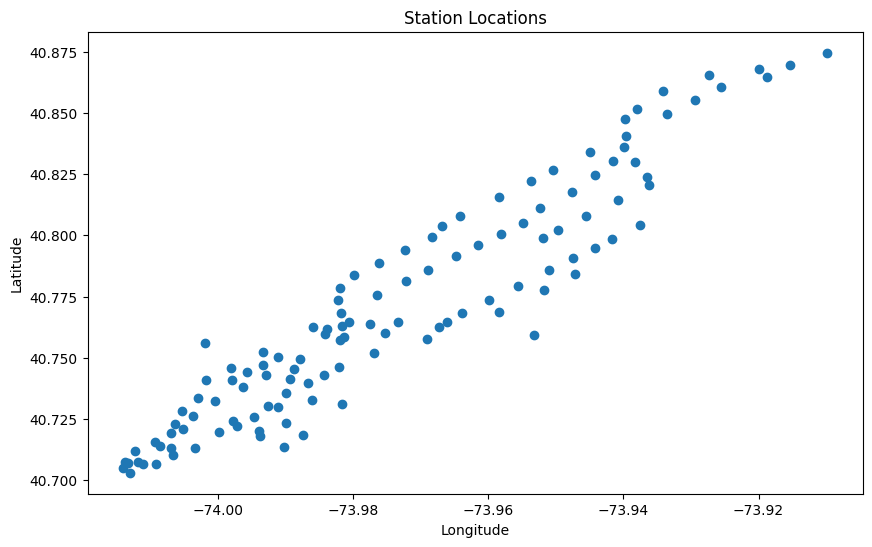

In [29]:
plt.scatter(mapping['longitude'], mapping['latitude'])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Station Locations')

plt.show()

It's a very rough plot but we can see the general outline of manhattan. Things are all checking out!
<br><br>
We'll save it to a csv file as well in case we need it later to map station complexes to zones.

In [30]:
mapping.to_csv('station_complex_mapping.csv', index=False)

### The actual mapping:
---
**The Problem:** 
- Initially, I tested merging based off the latitude and longitude columns in both dataframes.
- This did not work due to a slight difference in decimal points in both datasets.
- I tried rounding both to 3,4,5 decimal places each. Still, with 5 decimal points there was still a slight mismatch. With 3 and 4 decimal places, the co-ordinates were not accurate enough to map complexes correctly.
- I also tested creating a georeference column in the January data. This also not work presumably for similar reasons, as logically it didn't fix the inherent decimal points issues.

**The Solution:**
- The best solution we could think of was an approximation based off distances between the co-ordinates.
- Essentially, for each co-ordinate pair in the January data, calcualte the haversine distance between it and all the station complexes in the mapping table.
- The shortest distance (aka closest station complex), is then added to the January data in a new column.
- The approximation is close enough hopefully, and finally provides a common measure for each station complex for our model.

We need to convert to radians first for the calculation to work. We'll define two functions to convert both to and from radians.

In [31]:
# function to convert degrees to radians
def deg2rad(degrees):
    return degrees * np.pi / 180

# function to convert radians to degrees
def rad2deg(radians):
    return radians * 180 / np.pi

In [32]:
# convert lat-long in mapping to radians
mapping[['latitude', 'longitude']] = deg2rad(mapping[['latitude', 'longitude']])

# do the same for df
df[['latitude', 'longitude']] = deg2rad(df[['latitude', 'longitude']])

# build the tree from mapping
tree = BallTree(mapping[['latitude', 'longitude']].values, metric='haversine')

# query the nearest lat-long in mapping from df
distances, indices = tree.query(df[['latitude', 'longitude']].values)

# map the indices to station_complex
df['station_complex'] = mapping.iloc[indices.ravel()]['station_complex'].values

We can convert the latitude and longitude back now that the mapping is complete.

In [33]:
# convert lat-long in mapping back to degrees
mapping[['latitude', 'longitude']] = rad2deg(mapping[['latitude', 'longitude']])

# do the same for df
df[['latitude', 'longitude']] = rad2deg(df[['latitude', 'longitude']])

In [34]:
df

,Complex_id,Station,station_id,stop_name,borough,latitude,longitude,Line Name,Division,Date,...,Entries,Exits,turnstile_id,timestamp,Entries_diff,Exits_diff,Hour,Day,Time Block,station_complex
395138,613,59 ST,7.0,Lexington Av/59 St,M,40.762660,-73.967258,NQR456W,BMT,2022-01-01,...,7675872,2649548,A002R05102-00-00,2022-01-01 03:00:00,NaN,NaN,3,Saturday,0-3,"Lexington Av (N,R,W)/59 St (4,5,6)"
395139,613,59 ST,7.0,Lexington Av/59 St,M,40.762660,-73.967258,NQR456W,BMT,2022-01-01,...,7675876,2649551,A002R05102-00-00,2022-01-01 07:00:00,4.0,3.0,7,Saturday,4-7,"Lexington Av (N,R,W)/59 St (4,5,6)"
395140,613,59 ST,7.0,Lexington Av/59 St,M,40.762660,-73.967258,NQR456W,BMT,2022-01-01,...,7675887,2649594,A002R05102-00-00,2022-01-01 11:00:00,11.0,43.0,11,Saturday,8-11,"Lexington Av (N,R,W)/59 St (4,5,6)"
395141,613,59 ST,7.0,Lexington Av/59 St,M,40.762660,-73.967258,NQR456W,BMT,2022-01-01,...,7675895,2649626,A002R05102-00-00,2022-01-01 15:00:00,8.0,32.0,15,Saturday,12-15,"Lexington Av (N,R,W)/59 St (4,5,6)"
395142,613,59 ST,7.0,Lexington Av/59 St,M,40.762660,-73.967258,NQR456W,BMT,2022-01-01,...,7675920,2649657,A002R05102-00-00,2022-01-01 19:00:00,25.0,31.0,19,Saturday,16-19,"Lexington Av (N,R,W)/59 St (4,5,6)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13205,471,34 ST-HUDSON YD,471.0,34 St - 11 Av,M,40.755882,-74.001910,7,IRT,2022-01-31,...,1,287,R551R07201/05/2001,2022-01-31 07:00:00,0.0,0.0,7,Monday,4-7,34 St-Hudson Yards (7)
13206,471,34 ST-HUDSON YD,471.0,34 St - 11 Av,M,40.755882,-74.001910,7,IRT,2022-01-31,...,1,287,R551R07201/05/2001,2022-01-31 11:00:00,0.0,0.0,11,Monday,8-11,34 St-Hudson Yards (7)
13207,471,34 ST-HUDSON YD,471.0,34 St - 11 Av,M,40.755882,-74.001910,7,IRT,2022-01-31,...,1,287,R551R07201/05/2001,2022-01-31 15:00:00,0.0,0.0,15,Monday,12-15,34 St-Hudson Yards (7)
13208,471,34 ST-HUDSON YD,471.0,34 St - 11 Av,M,40.755882,-74.001910,7,IRT,2022-01-31,...,1,287,R551R07201/05/2001,2022-01-31 19:00:00,0.0,0.0,19,Monday,16-19,34 St-Hudson Yards (7)


In [35]:
df.isnull().sum()

Complex_id             0
Station                0
station_id             0
stop_name              0
borough                0
latitude               0
longitude              0
Line Name              0
Division               0
Date                   0
Time                   0
Description            0
Entries                0
Exits                  0
turnstile_id           0
timestamp              0
Entries_diff        2228
Exits_diff          2221
Hour                   0
Day                    0
Time Block         26875
station_complex        0
dtype: int64

In [36]:
unique_df = df['station_complex'].unique()
unique_df2 = df2['station_complex'].unique()

# Finding matches
matches = np.intersect1d(unique_df, unique_df2)

# Find non-matches
non_matches_df = np.setdiff1d(unique_df, matches)
non_matches_df2 = np.setdiff1d(unique_df2, matches)

# Count the number of matches and non-matches
num_matches = len(matches)
num_non_matches_df = len(non_matches_df)
num_non_matches_df2 = len(non_matches_df2)

print("Number of matching unique values:", num_matches)
print("Number of non-matching unique values in df:", num_non_matches_df)
print("Number of non-matching unique values in df2:", num_non_matches_df2)

Number of matching unique values: 119
Number of non-matching unique values in df: 0
Number of non-matching unique values in df2: 1


**Observations:**
- The mapping has worked.
- There are no null values or rows which mapped unsuccesfully!
- The complexes seem to have matched correctly when comparing to the station names.
- There are only 119 instead of 120 complexes.
- However, this is the closest we can get and good enough for our model.

I'm happy with the newly cleaned January data. I will save it as a csv file in case we need to return at a later date and make any changes. The next step will be dropping irrelevant features and merging ones required for modelling into one dataframe, so we finally have data from January-December in one dataset.

In [37]:
df.to_csv('2022_january_subway_data_cleaned_v2.csv', index=False)

## Merging for Machine Learning Model
---
We don't need to keep all the columns for the machine learning model. Our first model will contain a station complex, and date time features as input. I do save the cleaned January data beforehand in case we revisit or add more features.
<br><br>
**Very last cleaning steps:**
Before merging, we do need to perform one last bit of cleaning. Currently, the January data has two small issues:
- It is still counting entries per turnstile, instead of per complex
- It is using 4-hour observation windows. We will need to convert it to hourly somehow 

**Grouping Entries by Station Complex:**

In [38]:
df_sorted = df.sort_values(['station_complex', 'timestamp'])
df_grouped = df_sorted.groupby(['station_complex', 'timestamp']).agg({'Entries_diff': 'sum'}).reset_index()

In [39]:
df_grouped

,station_complex,timestamp,Entries_diff
0,1 Av (L),2022-01-01 03:00:00,0.0
1,1 Av (L),2022-01-01 07:00:00,139.0
2,1 Av (L),2022-01-01 11:00:00,298.0
3,1 Av (L),2022-01-01 15:00:00,670.0
4,1 Av (L),2022-01-01 19:00:00,897.0
...,...,...,...
23378,"West 4 St-Washington Sq (A,B,C,D,E,F,M)",2022-01-31 08:00:00,439.0
23379,"West 4 St-Washington Sq (A,B,C,D,E,F,M)",2022-01-31 08:37:19,95.0
23380,"West 4 St-Washington Sq (A,B,C,D,E,F,M)",2022-01-31 12:00:00,1230.0
23381,"West 4 St-Washington Sq (A,B,C,D,E,F,M)",2022-01-31 16:00:00,2385.0


**Getting hourly Entries:**<br>
Since there is no way to determing the actual hourly entries given the old format, we will:
- Divide the entries for the 4 hour window by 4 to get the average per hour
- For each row, create 4 rows for that hour and the 3 hours prior and fill these with the average entries.
- E.g For a 6pm observation, a new row for 3, 4, 5 and 6pm is made with average entries
- This is an approximate and will hopefully suffice in terms of accuracy

In [40]:
df_grouped['timestamp'] = pd.to_datetime(df_grouped['timestamp'])
df_grouped.set_index('timestamp', inplace=True)

df_hourly = pd.DataFrame()

# For each station_complex
for station, data in df_grouped.groupby('station_complex'):

    # Resample to the start of each hour, forward-filling the station_complex
    data_hourly = data.resample('H').ffill()

    # Divide 'ENTRIESn_hourly' by 4 to distribute entries evenly across the hours
    data_hourly['Entries_diff'] = data_hourly['Entries_diff'] / 4

    # Append to the result DataFrame
    df_hourly = pd.concat([df_hourly, data_hourly])

# Reset the index
df_hourly.reset_index(inplace=True)

In [41]:
df_hourly

,timestamp,station_complex,Entries_diff
0,2022-01-01 03:00:00,1 Av (L),0.00
1,2022-01-01 04:00:00,1 Av (L),0.00
2,2022-01-01 05:00:00,1 Av (L),0.00
3,2022-01-01 06:00:00,1 Av (L),0.00
4,2022-01-01 07:00:00,1 Av (L),34.75
...,...,...,...
88189,2022-01-31 16:00:00,"West 4 St-Washington Sq (A,B,C,D,E,F,M)",596.25
88190,2022-01-31 17:00:00,"West 4 St-Washington Sq (A,B,C,D,E,F,M)",596.25
88191,2022-01-31 18:00:00,"West 4 St-Washington Sq (A,B,C,D,E,F,M)",596.25
88192,2022-01-31 19:00:00,"West 4 St-Washington Sq (A,B,C,D,E,F,M)",596.25


In [42]:
df_hourly.describe()

,Entries_diff
count,88194.000000
mean,229.955071
std,355.790753
min,0.000000
25%,39.250000
50%,118.750000
75%,277.000000
max,5799.000000


In [43]:
num_zero_entries = (df_hourly['Entries_diff'] == 0).sum()
num_zero_entries

539

**Result:** 
- New hourly data looks good.
- Only 539 zero-counts, likely due to counters resetting is acceptable. This is approx. 0.6% of the overall entries. 
- Much better than the original 20% we saw in our first attempt!

We will graph the new hourly entries one last time just to make sure everything looks ok before merging our data for modelling.

In [44]:
# Extract the Hour, day of the week, and day of the month features
df_hourly['Hour'] = df_hourly['timestamp'].dt.hour
df_hourly['DayOfWeek'] = df_hourly['timestamp'].dt.dayofweek
df_hourly['DayOfMonth'] = df_hourly['timestamp'].dt.day
df_hourly['Month'] = df_hourly['timestamp'].dt.month

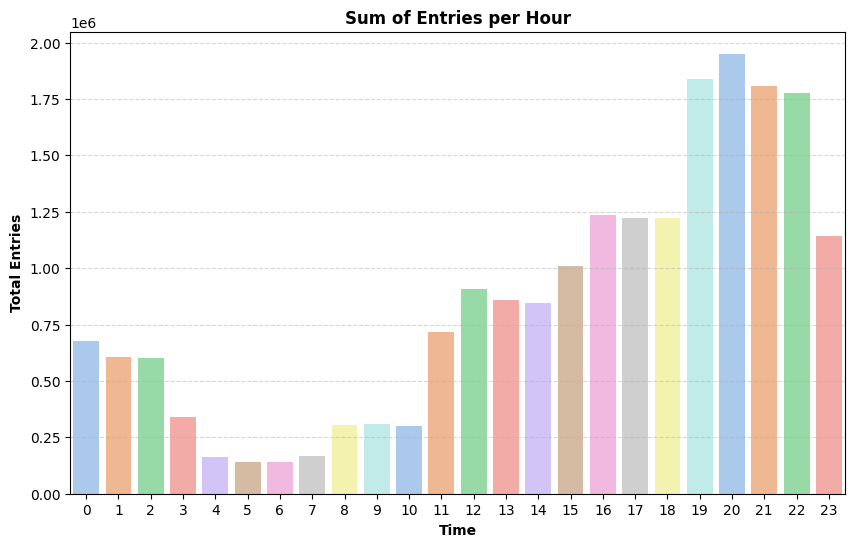

In [45]:
hourly_entries_diff = df_hourly.groupby('Hour')['Entries_diff'].sum()

# Plot the bar chart using seaborn
sns.barplot(x=hourly_entries_diff.index, y=hourly_entries_diff.values, palette='pastel')

plt.xlabel('Time', fontweight='bold')
plt.ylabel('Total Entries', fontweight='bold')
plt.title('Sum of Entries per Hour', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

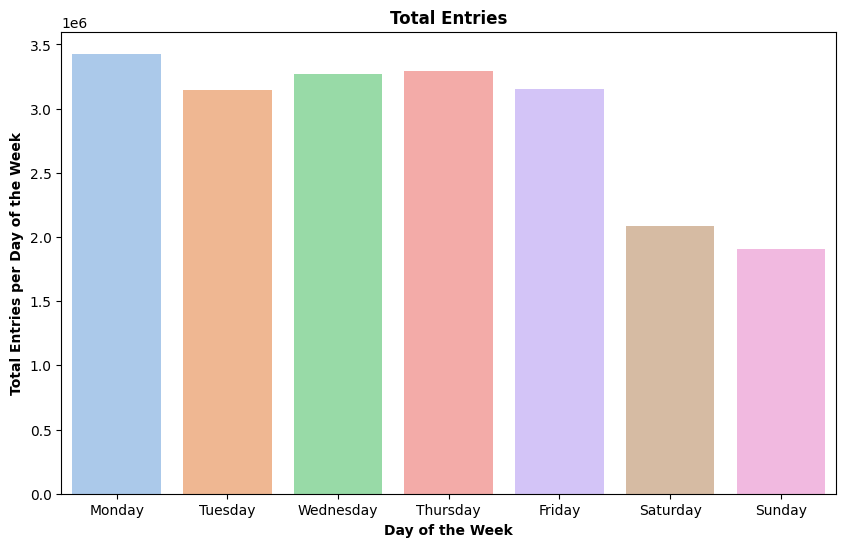

In [46]:
dayofweek_sum = df_hourly.groupby('DayOfWeek')['Entries_diff'].sum()

# Define the weekday names
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the bar chart using seaborn
sns.barplot(x=weekday_names, y=dayofweek_sum.values, palette='pastel')

plt.xlabel('Day of the Week', fontweight='bold')
plt.ylabel('Total Entries per Day of the Week', fontweight='bold')
plt.title('Total Entries', fontweight='bold')

# Display the plot
plt.show()

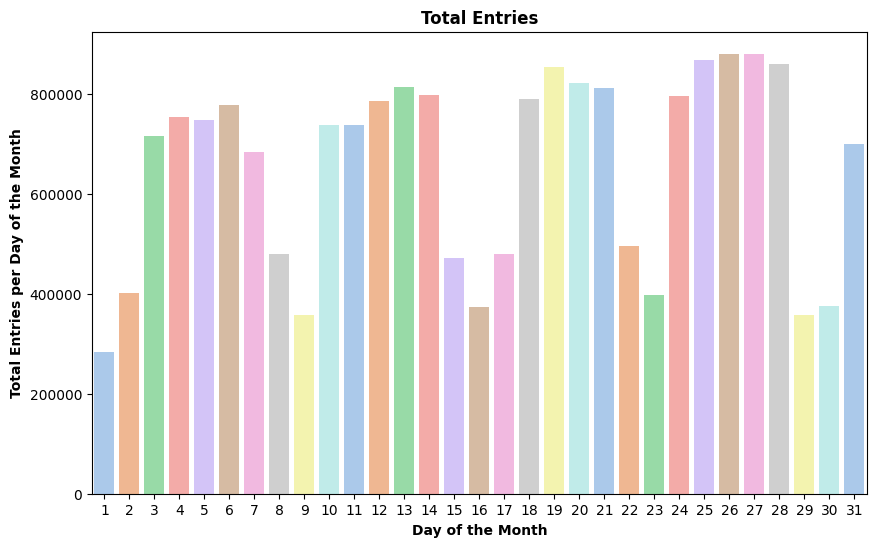

In [47]:
dayofmonth_sum = df_hourly.groupby('DayOfMonth')['Entries_diff'].sum()

sns.barplot(x=dayofmonth_sum.index, y=dayofmonth_sum.values, palette='pastel')

plt.xlabel('Day of the Month', fontweight='bold')
plt.ylabel('Total Entries per Day of the Month', fontweight='bold')
plt.title('Total Entries', fontweight='bold')

# Display the plot
plt.show()

**Final Observations:**
- This looks even better than up above.
- We can clearly see temporal trends across weekends vs weekdays, and hour of the day.
- Despite being an approximation, hourly entries look good and reflect the trend we've seen before across morning, afternoon, evening and night.
- We can finally merge the data and have all of 2022 entries ready for machine learning.

In [48]:
df_hourly

,timestamp,station_complex,Entries_diff,Hour,DayOfWeek,DayOfMonth,Month
0,2022-01-01 03:00:00,1 Av (L),0.00,3,5,1,1
1,2022-01-01 04:00:00,1 Av (L),0.00,4,5,1,1
2,2022-01-01 05:00:00,1 Av (L),0.00,5,5,1,1
3,2022-01-01 06:00:00,1 Av (L),0.00,6,5,1,1
4,2022-01-01 07:00:00,1 Av (L),34.75,7,5,1,1
...,...,...,...,...,...,...,...
88189,2022-01-31 16:00:00,"West 4 St-Washington Sq (A,B,C,D,E,F,M)",596.25,16,0,31,1
88190,2022-01-31 17:00:00,"West 4 St-Washington Sq (A,B,C,D,E,F,M)",596.25,17,0,31,1
88191,2022-01-31 18:00:00,"West 4 St-Washington Sq (A,B,C,D,E,F,M)",596.25,18,0,31,1
88192,2022-01-31 19:00:00,"West 4 St-Washington Sq (A,B,C,D,E,F,M)",596.25,19,0,31,1


### February - December data, dropping unnescessary columns
We will drop any columns not needed for our modelling, as it will make merging more seamless.

In [49]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951420 entries, 0 to 951419
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transit_timestamp   951420 non-null  object 
 1   station_complex_id  951420 non-null  object 
 2   station_complex     951420 non-null  object 
 3   borough             951420 non-null  object 
 4   routes              951420 non-null  object 
 5   payment_method      951420 non-null  object 
 6   ridership           951420 non-null  int64  
 7   transfers           951420 non-null  int64  
 8   latitude            951420 non-null  float64
 9   longitude           951420 non-null  float64
 10  Georeference        951420 non-null  object 
 11  date                951420 non-null  object 
 12  hour                951420 non-null  int64  
 13  day                 951420 non-null  object 
 14  month               951420 non-null  int64  
dtypes: float64(2), int64(4), object(9)

In [50]:
columns_to_drop = ['station_complex_id', 'borough', 'routes', 'payment_method',
                  'transfers', 'latitude', 'longitude', 'Georeference', 'date',
                  'hour', 'day', 'month']

In [51]:
df2 = df2.drop(columns=columns_to_drop)

In [52]:
# Extracting the same date-time features as January
df2['transit_timestamp'] = pd.to_datetime(df2['transit_timestamp'])

df2['Hour'] = df2['transit_timestamp'].dt.hour
df2['DayOfWeek'] = df2['transit_timestamp'].dt.dayofweek
df2['DayOfMonth'] = df2['transit_timestamp'].dt.day
df2['Month'] = df2['transit_timestamp'].dt.month

In [53]:
df2

,transit_timestamp,station_complex,ridership,Hour,DayOfWeek,DayOfMonth,Month
0,2022-02-01 10:00:00,WTC Cortlandt (1),87,10,1,1,2
1,2022-02-01 21:00:00,191 St (1),52,21,1,1,2
2,2022-02-01 02:00:00,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",76,2,1,1,2
3,2022-02-01 06:00:00,"Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortla...",378,6,1,1,2
4,2022-02-01 15:00:00,145 St (3),109,15,1,1,2
...,...,...,...,...,...,...,...
951415,2022-12-31 12:00:00,72 St (Q),602,12,5,31,12
951416,2022-12-31 20:00:00,Dyckman St (1),124,20,5,31,12
951417,2022-12-31 01:00:00,"57 St-7 Av (N,Q,R,W)",202,1,5,31,12
951418,2022-12-31 16:00:00,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",4755,16,5,31,12


And we rename columns in the January data to match the newer format.

In [54]:
df_hourly.rename(columns={'Entries_diff': 'ridership'}, inplace=True)
df_hourly.rename(columns={'timestamp': 'transit_timestamp'}, inplace=True)

In [55]:
merged_data = pd.concat([df_hourly, df2], ignore_index=True)

In [56]:
merged_data

,transit_timestamp,station_complex,ridership,Hour,DayOfWeek,DayOfMonth,Month
0,2022-01-01 03:00:00,1 Av (L),0.00,3,5,1,1
1,2022-01-01 04:00:00,1 Av (L),0.00,4,5,1,1
2,2022-01-01 05:00:00,1 Av (L),0.00,5,5,1,1
3,2022-01-01 06:00:00,1 Av (L),0.00,6,5,1,1
4,2022-01-01 07:00:00,1 Av (L),34.75,7,5,1,1
...,...,...,...,...,...,...,...
1039609,2022-12-31 12:00:00,72 St (Q),602.00,12,5,31,12
1039610,2022-12-31 20:00:00,Dyckman St (1),124.00,20,5,31,12
1039611,2022-12-31 01:00:00,"57 St-7 Av (N,Q,R,W)",202.00,1,5,31,12
1039612,2022-12-31 16:00:00,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",4755.00,16,5,31,12


In [57]:
merged_data.to_csv('2022_cleaned_subway_data_for_modelling.csv', index=False)

We save the fully merged 2022 data, and now can use it in our models.

# Weather Plots
---
We will investigate both rainfall and snow fall and it's impacts on subway ridership to see if it's worth including in our model. The steps taken are the same as the taxi data weather plots, so refer to that if any steps are not clear.

In [5]:
subway_data = pd.read_csv("2022_cleaned_subway_data_for_modelling.csv")

In [6]:
weather = pd.read_csv("WeatherDataCentralPark.csv")

In [7]:
weather

,STATION,NAME,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08
0,USW00094728,"NY CITY CENTRAL PARK, NY US",2022-01-01,1.4,20.1,0.0,0.0,NaN,13.3,10.0,60,60,4.5,6.7,1.0,NaN,NaN,NaN,NaN,NaN
1,USW00094728,"NY CITY CENTRAL PARK, NY US",2022-01-02,2.6,1.0,0.0,0.0,NaN,15.0,2.8,300,300,8.1,13.4,1.0,NaN,NaN,NaN,NaN,NaN
2,USW00094728,"NY CITY CENTRAL PARK, NY US",2022-01-03,4.4,0.0,0.0,0.0,NaN,2.8,-5.5,350,360,8.1,13.0,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00094728,"NY CITY CENTRAL PARK, NY US",2022-01-04,2.7,0.0,0.0,0.0,NaN,1.1,-7.1,300,290,6.3,10.3,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00094728,"NY CITY CENTRAL PARK, NY US",2022-01-05,2.5,5.8,0.0,0.0,NaN,8.3,-0.5,220,240,6.7,10.3,1.0,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,USW00094728,"NY CITY CENTRAL PARK, NY US",2022-12-27,2.5,0.0,0.0,0.0,NaN,1.7,-1.6,240,220,5.4,7.6,NaN,NaN,NaN,NaN,NaN,NaN
361,USW00094728,"NY CITY CENTRAL PARK, NY US",2022-12-28,2.3,0.0,0.0,0.0,NaN,8.3,0.6,220,210,7.2,11.6,NaN,NaN,NaN,NaN,NaN,1.0
362,USW00094728,"NY CITY CENTRAL PARK, NY US",2022-12-29,2.7,0.0,0.0,0.0,NaN,10.6,4.4,240,220,6.3,9.4,NaN,NaN,NaN,NaN,NaN,NaN
363,USW00094728,"NY CITY CENTRAL PARK, NY US",2022-12-30,1.3,0.0,0.0,0.0,NaN,16.7,7.8,210,220,4.0,7.2,NaN,NaN,NaN,NaN,NaN,1.0


In [8]:
weather = weather.drop(['STATION', 'NAME', 'TAVG', 'WT01', 'WT02', 'WT03', 'WT04', 'WT06', 'WT08', 'TMAX', 'TMIN',
                       'WDF2', 'WDF5', 'WSF2', 'WSF5'], axis=1)

In [9]:
weather

,DATE,AWND,PRCP,SNOW,SNWD
0,2022-01-01,1.4,20.1,0.0,0.0
1,2022-01-02,2.6,1.0,0.0,0.0
2,2022-01-03,4.4,0.0,0.0,0.0
3,2022-01-04,2.7,0.0,0.0,0.0
4,2022-01-05,2.5,5.8,0.0,0.0
...,...,...,...,...,...
360,2022-12-27,2.5,0.0,0.0,0.0
361,2022-12-28,2.3,0.0,0.0,0.0
362,2022-12-29,2.7,0.0,0.0,0.0
363,2022-12-30,1.3,0.0,0.0,0.0


In [10]:
subway_data['transit_timestamp'] = pd.to_datetime(subway_data['transit_timestamp'])

# Extract the date part and create a new column with the format 'YYYY-MM-DD'
subway_data['date'] = subway_data['transit_timestamp'].dt.date

In [11]:
subway_data['date'] = pd.to_datetime(subway_data['date'])
weather['DATE'] = pd.to_datetime(weather['DATE'])

In [12]:
subway_data = pd.DataFrame(pd.merge(subway_data, weather, left_on='date', right_on='DATE')).drop('DATE', axis=1)

In [13]:
subway_data

,transit_timestamp,station_complex,ridership,Hour,DayOfWeek,DayOfMonth,Month,date,AWND,PRCP,SNOW,SNWD
0,2022-01-01 03:00:00,1 Av (L),0.00,3,5,1,1,2022-01-01,1.4,20.1,0.0,0.0
1,2022-01-01 04:00:00,1 Av (L),0.00,4,5,1,1,2022-01-01,1.4,20.1,0.0,0.0
2,2022-01-01 05:00:00,1 Av (L),0.00,5,5,1,1,2022-01-01,1.4,20.1,0.0,0.0
3,2022-01-01 06:00:00,1 Av (L),0.00,6,5,1,1,2022-01-01,1.4,20.1,0.0,0.0
4,2022-01-01 07:00:00,1 Av (L),34.75,7,5,1,1,2022-01-01,1.4,20.1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1039609,2022-12-31 12:00:00,72 St (Q),602.00,12,5,31,12,2022-12-31,0.8,7.1,0.0,0.0
1039610,2022-12-31 20:00:00,Dyckman St (1),124.00,20,5,31,12,2022-12-31,0.8,7.1,0.0,0.0
1039611,2022-12-31 01:00:00,"57 St-7 Av (N,Q,R,W)",202.00,1,5,31,12,2022-12-31,0.8,7.1,0.0,0.0
1039612,2022-12-31 16:00:00,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",4755.00,16,5,31,12,2022-12-31,0.8,7.1,0.0,0.0


In [16]:
bins = [-1, 0, 5, 10, 15, 20, float('inf')]
labels = ['0mm ', '0-5 mm', '5-10 mm', '10- 15mm', '15-20 mm', '20+ mm']
subway_data['rainfall_level'] = pd.cut(subway_data['PRCP'], bins=bins, labels=labels)

In [18]:
bins = [-1, 0, 50, 100, 150, 200, float('inf')]
labels = ['0 mm', '0-50 mm', '50-100 mm', '100-150 mm', '150-200 mm', '200+ mm']
subway_data['snow_level'] = pd.cut(subway_data['SNOW'], bins=bins, labels=labels)

The only difference in the process here is that we sum by the ridership columns instead of counting the number of rows per date, as one row could capture many riders.

In [19]:
daily_ridership = subway_data.groupby(['date'])['ridership'].sum()

# Merge daily ridership with rainfall/snow levels
df_daily_subway = subway_data[['date', 'rainfall_level', 'snow_level']].drop_duplicates()
daily_ridership = daily_ridership.reset_index()
df_daily_subway = pd.merge(df_daily_subway, daily_ridership, on='date')

In [20]:
average_ridership_rain = df_daily_subway.groupby('rainfall_level')['ridership'].mean()

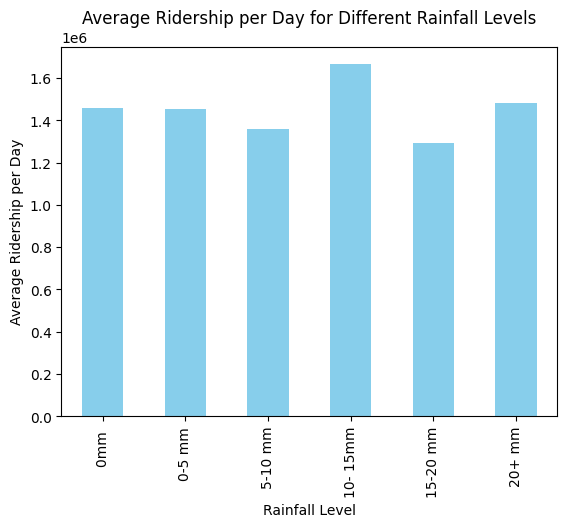

In [21]:
average_ridership_rain.plot(kind='bar', color='skyblue')
plt.xlabel('Rainfall Level (mm)', fontweight='bold')
plt.ylabel('Average Ridership per Day', fontweight='bold')
plt.title('Average Ridership per Day for Different Rainfall Levels', fontweight='bold')
plt.show()

In [22]:
average_ridership_rain

rainfall_level
0mm         1.456346e+06
0-5 mm      1.455339e+06
5-10 mm     1.360391e+06
10- 15mm    1.665200e+06
15-20 mm    1.290749e+06
20+ mm      1.481781e+06
Name: ridership, dtype: float64

**Observations:**
- Much like the taxi data, rainfaill seems to have little to no impact on ridership.
- There's very little variation between different brackets.

In [23]:
average_ridership_snow = df_daily_subway.groupby('snow_level')['ridership'].mean()

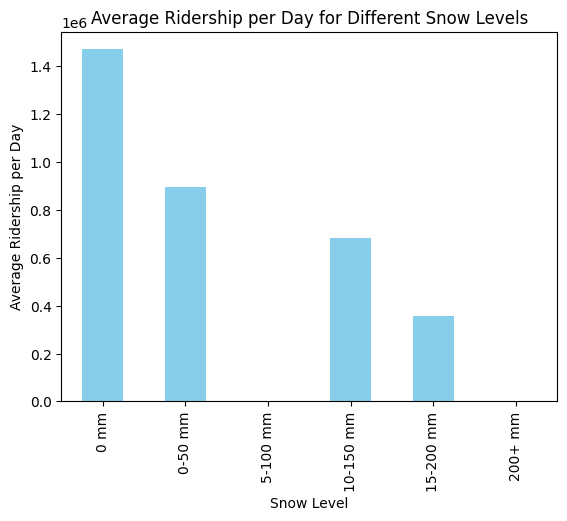

In [24]:
average_ridership_snow.plot(kind='bar', color='skyblue')
plt.xlabel('Snow Level (mm)', fontweight='bold')
plt.ylabel('Average Ridership per Day', fontweight='bold')
plt.title('Average Ridership per Day for Different Snow Levels', fontweight='bold')
plt.show()

In [25]:
average_ridership_snow

snow_level
0 mm         1.470396e+06
0-50 mm      8.967802e+05
5-100 mm              NaN
10-150 mm    6.836860e+05
15-200 mm    3.577758e+05
200+ mm               NaN
Name: ridership, dtype: float64

**Observations:**
- Snow on the other hand does appear to impact ridership.
- But again, we face the same issues of a lack of any observations for the 50-100mm and 200mm + brackets due to the small sample size
- While it does have an impact, again it will not be used in our model for the same reasons as outlined in the taxi data.